# Decompose HSC observed galaxy image as disk + bulge

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight ==  0.1.6

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'galight_HSC_QSO.ipynb', only that there is no AGN and galaxy are fitted as double components.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1Axwo-aD5yFrkuHIlYBsQ8ma1nHRpcAHg/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/galaxy/18184_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/galaxy/18184_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


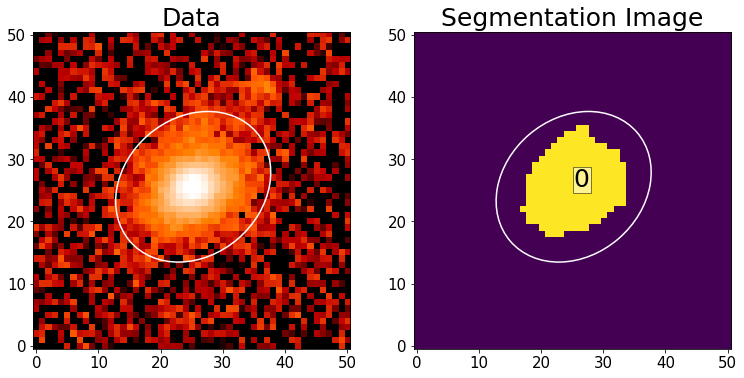

label     xcentroid          ycentroid      ...     kron_flux      kron_fluxerr
                                            ...                                
----- ------------------ ------------------ ... ------------------ ------------
    1 25.237777960288344 25.563875345646768 ... 170.89522397895007          nan


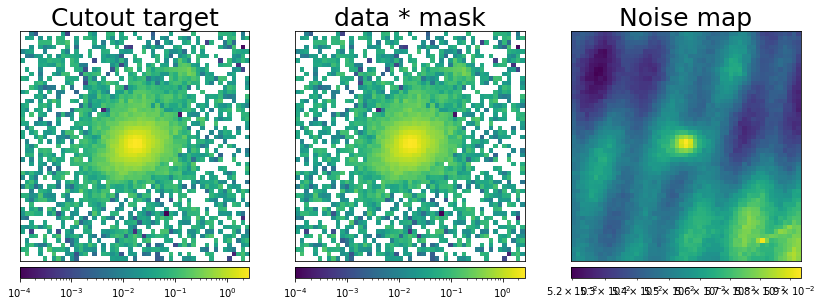

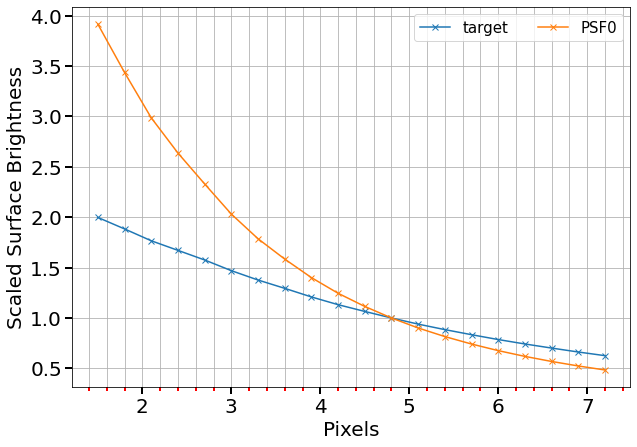

The PSF is not a box size, will cut it to a box size automatically.
The data_process is ready to go to pass to FittingSpecify!


In [2]:
from galight.data_process import DataProcess

#RA, DEC information of the galaxy:
galaxy_RA, galaxy_DEC = 150.1217832, 2.394535983
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [galaxy_RA, galaxy_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=25, create_mask = False, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


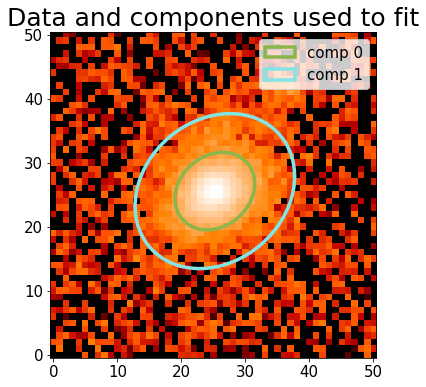

In [3]:
#Modify the fitting of the component (i.e., galaxy) id = 0 into to components (i.e., bulge + disk)
import copy
apertures = copy.deepcopy(data_process.apertures)
comp_id = 0 
add_aperture0 = copy.deepcopy(apertures[comp_id])
#This setting assigns comp0 as 'bulge' and comp1 as 'disk'
add_aperture0.a, add_aperture0.b = add_aperture0.a/2, add_aperture0.b/2
apertures = apertures[:comp_id] + [add_aperture0] + apertures[comp_id:]
data_process.apertures = apertures #Pass apertures to the data_process

#Adding a prior so that 1)the size of the bulge is within a range to the disk size. 2) disk have more ellipticity.
import lenstronomy.Util.param_util as param_util
def condition_bulgedisk(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_special, kwargs_extinction):
    logL = 0
    #note that the Comp[0] is the bulge and the Comp[1] is the disk.
    phi0, q0 = param_util.ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])
    phi1, q1 = param_util.ellipticity2phi_q(kwargs_lens_light[1]['e1'], kwargs_lens_light[1]['e2'])
    cond_0 = (kwargs_lens_light[0]['R_sersic'] > kwargs_lens_light[1]['R_sersic'] * 0.9)
    cond_1 = (kwargs_lens_light[0]['R_sersic'] < kwargs_lens_light[1]['R_sersic']*0.15)
    cond_2 = (q0 < q1)
    if cond_0 or cond_1 or cond_2:
        logL -= 10**15
    return logL

#Start to produce the class and params for fitting.
#For more details, see notebook galight_HSC_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
#The 'fix_n_list' will fix Sersic_n as 4 for the comp0, and as 1 for the comp1.
fit_sepc.prepare_fitting_seq(point_source_num = 0, fix_n_list= [[0,4], [1,1]],condition=condition_bulgedisk)

#The settings of the parameters is the dict defined by fit_sepc.kwargs_params. One can modify the values herein to change the default setting manually. 

#Plot the initial settings for fittings. 
fit_sepc.build_fitting_seq()
fit_sepc.plot_fitting_sets()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.1656626174588023 reduced X^2 of best position
-1508.9502583004196 logL
2589.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.8471094199307331, 'n_sersic': 4, 'e1': 0.1593854227360442, 'e2': -0.11227843998130445, 'center_x': -0.025920955124524133, 'center_y': 0.07186143353247892}, {'amp': 1, 'R_sersic': 1.1973776949484358, 'n_sersic': 1, 'e1': -0.13361905458992407, 'e2': -0.2327352526904117, 'center_x': -0.07488008173798466, 'center_y': 0.16290692658053557}] lens light result
[] point source result
{} special param result
3.450836420059204 time used for  PSO
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-1.157081397010449 reduced X^2 of best position
-1497.8418684300264 logL
2589.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.654029745815276, 'n_sersic': 4, 'e1': 0.1231

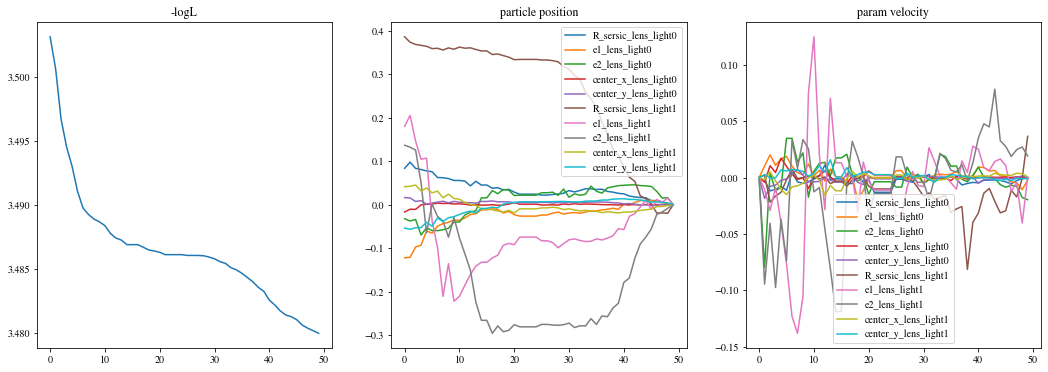

<Figure size 432x288 with 0 Axes>

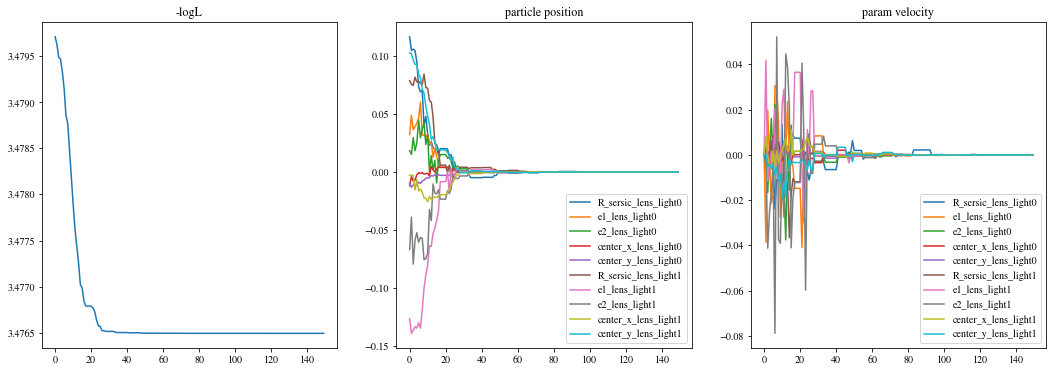

<Figure size 432x288 with 0 Axes>

-1.1517430745328923 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.151743074532892


/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:533: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


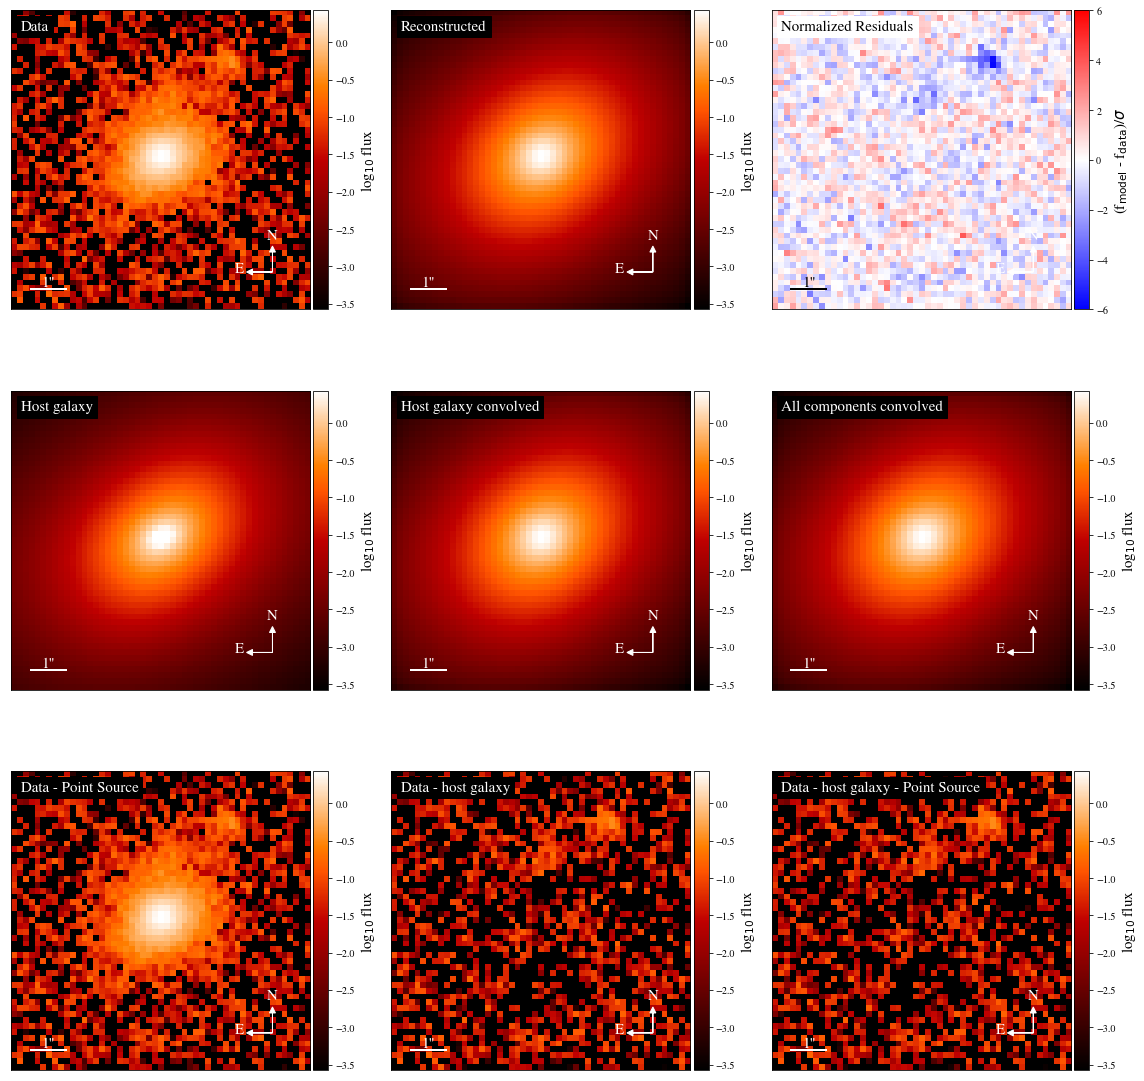

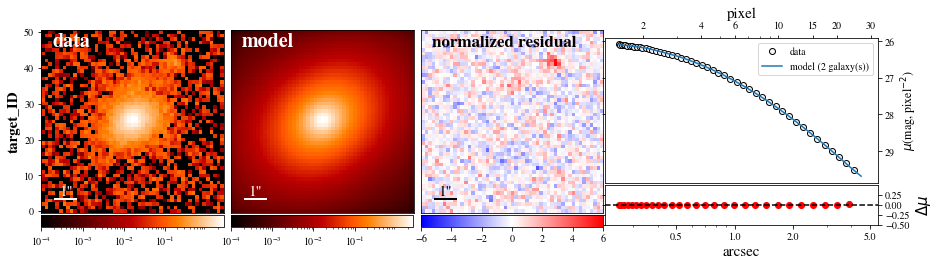

In [4]:
#Setting the fitting method and run.
from galight.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_galaxy_result', fitting_level=['shallow', 'deep'])

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         input template: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         input template: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'PSO'])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()


#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

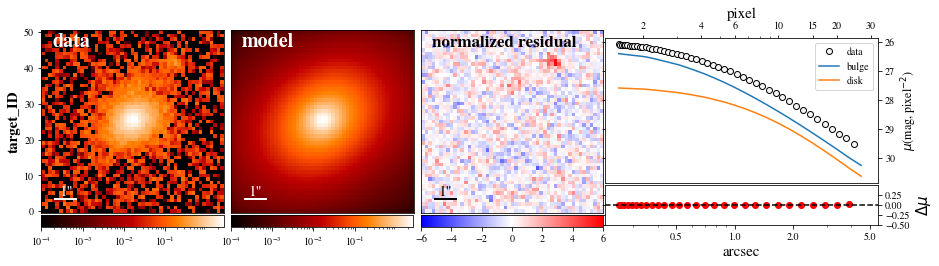

In [5]:
from galight.tools.plot_tools import total_compare
data = fit_run.fitting_specify_class.kwargs_data['image_data']
noise = fit_run.fitting_specify_class.kwargs_data['noise_map']
galaxy_list = fit_run.image_host_list
galaxy_total_image = np.zeros_like(galaxy_list[0])
for i in range(len(galaxy_list)):
    galaxy_total_image = galaxy_total_image+galaxy_list[i]
model = galaxy_total_image
norm_residual = (data - model)/noise
flux_list_2d = [data, model, norm_residual]
label_list_2d = ['data', 'model', 'normalized residual']
flux_list_1d = [data, galaxy_list[0], galaxy_list[1]]
label_list_1d = ['data', 'bulge', 'disk']
total_compare(flux_list_2d, label_list_2d, flux_list_1d, label_list_1d, deltaPix = fit_run.fitting_specify_class.deltaPix,
                      zp=fit_run.zp, if_annuli=False, arrows= False, show_plot = False,
                      target_ID = 'target_ID')


In [6]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_galaxy_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 17.326393566371408,
  'R_sersic': 0.654029745815276,
  'n_sersic': 4,
  'e1': 0.12313275423865584,
  'e2': -0.12827979445858556,
  'center_x': -0.014289852115029141,
  'center_y': 0.08246340562967801,
  'phi_G': -0.4029338956466413,
  'q': 0.6980627588497108,
  'flux_sersic_model': 117.25987182983069,
  'flux_within_frame': 108.07174648941532,
  'magnitude': 21.915719575189282},
 {'amp': 8.530021987546561,
  'R_sersic': 1.036850221109121,
  'n_sersic': 1,
  'e1': -0.007901055685443348,
  'e2': -0.17763716498216622,
  'center_x': -0.07232624786266509,
  'center_y': 0.05454647094983743,
  'phi_G': -0.8076228243169283,
  'q': 0.6980627254807262,
  'flux_sersic_model': 76.58008185742155,
  'flux_within_frame': 76.29742229509864,
  'magnitude': 22.293725336040886}]